# 13.3c: Monument Valley Simulation (Uniform Ball)

**Goal:** Test the Monument Valley hypothesis with **uniform ball** initialization instead of Gaussian.

## The Question

Qwen has 13 black holes with populations [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2].

In 13.3a we tested Gaussian initialization - it failed to reproduce Qwen's demographics.

In 13.3b we compared four distributions and found **uniform ball** produces different black hole structure than Gaussian.

**Monument Valley hypothesis (uniform ball version):**
1. Initialize 151,936 tokens **uniformly in ball of radius R** around centroid in float32
2. Quantize to bfloat16 → creates natural clustering
3. **Uniformly delete 149,715 tokens** (simulating random training selection)
4. Measure demographics of the 2,221 survivors

Key difference: **Uniform ball** has constant density (every region equally populated) vs Gaussian's center-heavy distribution.

We'll sweep radius R values and see if any match Qwen's demographics.

## Parameters

In [33]:
# Input
DEAD_TOKENS_PATH = "../data/tensors/13.1a_dead_tokens.safetensors"

# Monument Valley parameters
N_TOTAL_TOKENS = 151936  # Full vocabulary
N_SURVIVORS = 2221       # Match Qwen's dead token count exactly
N_DIMS = 2560

# Scale (radius) sweep range (log-spaced between min and max)
SCALE_MIN = 1e-7
SCALE_MAX = 1e-6
N_SCALE_SAMPLES = 100 # Start with broad sweep

# Trials per scale
N_TRIALS_PER_SCALE = 10

# Output
OUTPUT_PATH = "../data/tensors/13.3c_monument_valley_uniform_ball.safetensors"

# Figure settings
DPI = 150

RANDOM_SEED = 42

## Imports

In [34]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_file, save_file
from tqdm import tqdm

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# Check for MPS
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(f"Using device: {device}")
print("✓ Imports complete")

Using device: mps
✓ Imports complete


## Generate Scale Values

In [35]:
# Generate log-spaced scale values
SCALE_VALUES = np.logspace(np.log10(SCALE_MIN), np.log10(SCALE_MAX), N_SCALE_SAMPLES).tolist()

print(f"\nScale (radius) sweep range:")
print(f"  Min: {SCALE_MIN:.2e}")
print(f"  Max: {SCALE_MAX:.2e}")
print(f"  Samples: {N_SCALE_SAMPLES}")
print(f"\nScale values:")
for i, scale in enumerate(SCALE_VALUES):
    print(f"  [{i+1:2d}] {scale:.6e}")


Scale (radius) sweep range:
  Min: 1.00e-07
  Max: 1.00e-06
  Samples: 100

Scale values:
  [ 1] 1.000000e-07
  [ 2] 1.023531e-07
  [ 3] 1.047616e-07
  [ 4] 1.072267e-07
  [ 5] 1.097499e-07
  [ 6] 1.123324e-07
  [ 7] 1.149757e-07
  [ 8] 1.176812e-07
  [ 9] 1.204504e-07
  [10] 1.232847e-07
  [11] 1.261857e-07
  [12] 1.291550e-07
  [13] 1.321941e-07
  [14] 1.353048e-07
  [15] 1.384886e-07
  [16] 1.417474e-07
  [17] 1.450829e-07
  [18] 1.484968e-07
  [19] 1.519911e-07
  [20] 1.555676e-07
  [21] 1.592283e-07
  [22] 1.629751e-07
  [23] 1.668101e-07
  [24] 1.707353e-07
  [25] 1.747528e-07
  [26] 1.788650e-07
  [27] 1.830738e-07
  [28] 1.873817e-07
  [29] 1.917910e-07
  [30] 1.963041e-07
  [31] 2.009233e-07
  [32] 2.056512e-07
  [33] 2.104904e-07
  [34] 2.154435e-07
  [35] 2.205131e-07
  [36] 2.257020e-07
  [37] 2.310130e-07
  [38] 2.364489e-07
  [39] 2.420128e-07
  [40] 2.477076e-07
  [41] 2.535364e-07
  [42] 2.595024e-07
  [43] 2.656088e-07
  [44] 2.718588e-07
  [45] 2.782559e-07
  [46] 2.

## Load Qwen Dead Token Data (for centroid)

In [36]:
print("\nLoading Qwen dead token data...\n")

data = load_file(DEAD_TOKENS_PATH)
qwen_centroid = data['weighted_centroid'].to(device)
qwen_embeddings = data['dead_embeddings_float32']

# Get Qwen's black hole demographics for comparison
qwen_unique, qwen_inverse, qwen_counts = torch.unique(
    qwen_embeddings, dim=0, return_inverse=True, return_counts=True
)
qwen_bh_counts = qwen_counts[qwen_counts >= 2]
qwen_demographics = torch.sort(qwen_bh_counts, descending=True)[0].tolist()

print(f"✓ Loaded centroid: {qwen_centroid.shape}")
print(f"  Centroid norm: {torch.norm(qwen_centroid, p=2).item():.6f}")
print(f"\nQwen demographics (target):")
print(f"  {qwen_demographics}")
print(f"  n_black_holes: {len(qwen_demographics)}")
print(f"  largest_bh: {qwen_demographics[0]}")


Loading Qwen dead token data...

✓ Loaded centroid: torch.Size([2560])
  Centroid norm: 0.370917

Qwen demographics (target):
  [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]
  n_black_holes: 13
  largest_bh: 814


## Monument Valley Simulation Function (Uniform Ball)

In [37]:
def run_monument_valley_trial(radius, centroid):
    """
    Run one Monument Valley trial with uniform ball initialization.
    
    Args:
        radius: Ball radius R for uniform sampling
        centroid: Center point for initialization (on MPS)
    
    Returns:
        dict with statistics
    """
    # 1. Sample uniformly from ball of radius R on MPS
    # Random directions (uniform on sphere)
    directions = torch.randn(N_TOTAL_TOKENS, N_DIMS, device=device)
    directions = directions / torch.norm(directions, dim=1, keepdim=True)
    
    # Random radii (uniform in volume)
    # For uniform density in n-dims, r ~ U(0,1)^(1/n)
    radii = torch.rand(N_TOTAL_TOKENS, device=device).pow(1.0 / N_DIMS) * radius
    
    init_f32 = centroid + directions * radii.unsqueeze(1)
    
    # 2. Quantize to bfloat16 (on MPS)
    init_bf16 = init_f32.to(torch.bfloat16)
    
    # 3. Uniformly sample N_SURVIVORS indices
    survivor_indices = torch.randperm(N_TOTAL_TOKENS, device=device)[:N_SURVIVORS]
    survivors = init_bf16[survivor_indices]  # [N_SURVIVORS, N_DIMS]
    
    # 4. Move to CPU for unique processing
    survivors_cpu = survivors.to('cpu', dtype=torch.float32)
    
    # 5. Get unique vectors and demographics
    unique, inverse, counts = torch.unique(
        survivors_cpu, dim=0, return_inverse=True, return_counts=True
    )
    
    n_unique = len(unique)
    n_singletons = (counts == 1).sum().item()
    
    # Black hole demographics
    bh_mask = counts >= 2
    bh_counts = counts[bh_mask]
    
    if len(bh_counts) > 0:
        sorted_bh_counts = torch.sort(bh_counts, descending=True)[0]
        n_black_holes = len(sorted_bh_counts)
        largest_bh = sorted_bh_counts[0].item()
        demographics = sorted_bh_counts.tolist()
    else:
        n_black_holes = 0
        largest_bh = 0
        demographics = []
    
    return {
        'n_unique': n_unique,
        'n_singletons': n_singletons,
        'n_black_holes': n_black_holes,
        'largest_bh': largest_bh,
        'demographics': demographics,
    }

print("✓ Defined Monument Valley trial function (uniform ball)")

✓ Defined Monument Valley trial function (uniform ball)


## Run Scale Sweep

In [38]:
print(f"\nRunning Monument Valley simulation (uniform ball)...\n")
print(f"Parameters:")
print(f"  Total tokens: {N_TOTAL_TOKENS:,}")
print(f"  Survivors: {N_SURVIVORS:,}")
print(f"  Survival rate: {N_SURVIVORS/N_TOTAL_TOKENS*100:.2f}%")
print(f"  Distribution: Uniform Ball")
print(f"  Scale values: {len(SCALE_VALUES)}")
print(f"  Trials per scale: {N_TRIALS_PER_SCALE}\n")

# Storage for results
all_results = {}  # scale -> list of trial results

# Sweep over scale values
for scale in tqdm(SCALE_VALUES, desc="Scale sweep"):
    scale_results = []
    
    # Run trials
    for trial_idx in tqdm(range(N_TRIALS_PER_SCALE), desc=f"R={scale:.1e}", leave=False):
        result = run_monument_valley_trial(radius=scale, centroid=qwen_centroid)
        scale_results.append(result)
    
    all_results[scale] = scale_results

print(f"\n✓ Completed {len(SCALE_VALUES)} scale values × {N_TRIALS_PER_SCALE} trials each")


Running Monument Valley simulation (uniform ball)...

Parameters:
  Total tokens: 151,936
  Survivors: 2,221
  Survival rate: 1.46%
  Distribution: Uniform Ball
  Scale values: 100
  Trials per scale: 10



Scale sweep: 100%|██████████| 100/100 [02:06<00:00,  1.27s/it]


✓ Completed 100 scale values × 10 trials each


## Aggregate Statistics Per Scale

In [39]:
print("\nAggregating statistics...\n")

summary_stats = []

for scale in SCALE_VALUES:
    results = all_results[scale]
    
    # Extract arrays
    n_unique_arr = np.array([r['n_unique'] for r in results])
    n_singletons_arr = np.array([r['n_singletons'] for r in results])
    n_black_holes_arr = np.array([r['n_black_holes'] for r in results])
    largest_bh_arr = np.array([r['largest_bh'] for r in results])
    
    # Compute summary
    summary = {
        'scale': scale,
        'n_unique_mean': n_unique_arr.mean(),
        'n_unique_std': n_unique_arr.std(),
        'n_singletons_mean': n_singletons_arr.mean(),
        'n_singletons_std': n_singletons_arr.std(),
        'n_black_holes_mean': n_black_holes_arr.mean(),
        'n_black_holes_std': n_black_holes_arr.std(),
        'largest_bh_mean': largest_bh_arr.mean(),
        'largest_bh_std': largest_bh_arr.std(),
    }
    
    summary_stats.append(summary)

print(f"✓ Aggregated statistics for {len(SCALE_VALUES)} scale values")


Aggregating statistics...

✓ Aggregated statistics for 100 scale values


## Display Summary Table

In [40]:
print(f"\n{'='*100}")
print(f"MONUMENT VALLEY RESULTS SUMMARY (UNIFORM BALL)")
print(f"{'='*100}\n")

print(f"Qwen targets:")
print(f"  n_black_holes: {len(qwen_demographics)}")
print(f"  largest_bh: {qwen_demographics[0]}")
print(f"  demographics: {qwen_demographics}\n")

print(f"{'Radius':>12} {'n_BH':>8} {'largest_BH':>12} {'n_unique':>10} {'n_single':>10}")
print("-" * 100)

for stats in summary_stats:
    scale = stats['scale']
    n_bh = stats['n_black_holes_mean']
    n_bh_std = stats['n_black_holes_std']
    largest = stats['largest_bh_mean']
    largest_std = stats['largest_bh_std']
    n_unique = stats['n_unique_mean']
    n_single = stats['n_singletons_mean']
    
    # Highlight if close to Qwen
    marker = ""
    if abs(n_bh - len(qwen_demographics)) < 2 and abs(largest - qwen_demographics[0]) < 100:
        marker = " ← MATCH"
    
    print(f"{scale:>12.6e} {n_bh:>5.1f}±{n_bh_std:<4.1f} {largest:>6.0f}±{largest_std:<5.0f} {n_unique:>7.1f} {n_single:>7.1f}{marker}")

print(f"\n{'='*100}")


MONUMENT VALLEY RESULTS SUMMARY (UNIFORM BALL)

Qwen targets:
  n_black_holes: 13
  largest_bh: 814
  demographics: [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]

      Radius     n_BH   largest_BH   n_unique   n_single
----------------------------------------------------------------------------------------------------
1.000000e-07   6.1±0.3    1440±19        7.7     1.6
1.023531e-07   6.3±0.5    1408±14        8.5     2.2
1.047616e-07   6.6±0.5    1395±23        8.8     2.2
1.072267e-07   7.2±0.7    1373±16        8.8     1.6
1.097499e-07   7.5±1.2    1358±15        9.2     1.7
1.123324e-07   7.7±0.9    1346±19       10.4     2.7
1.149757e-07   8.0±1.2    1310±24       11.2     3.2
1.176812e-07   8.3±0.6    1305±32       11.8     3.5
1.204504e-07   9.2±0.7    1269±22       12.7     3.5
1.232847e-07   9.8±1.0    1259±22       13.1     3.3
1.261857e-07  10.5±1.5    1239±35       13.5     3.0
1.291550e-07  11.5±1.5    1198±26       16.6     5.1
1.321941e-07  12.5±1.4    1178±18     

## Figure 1: Summary Statistics vs Scale

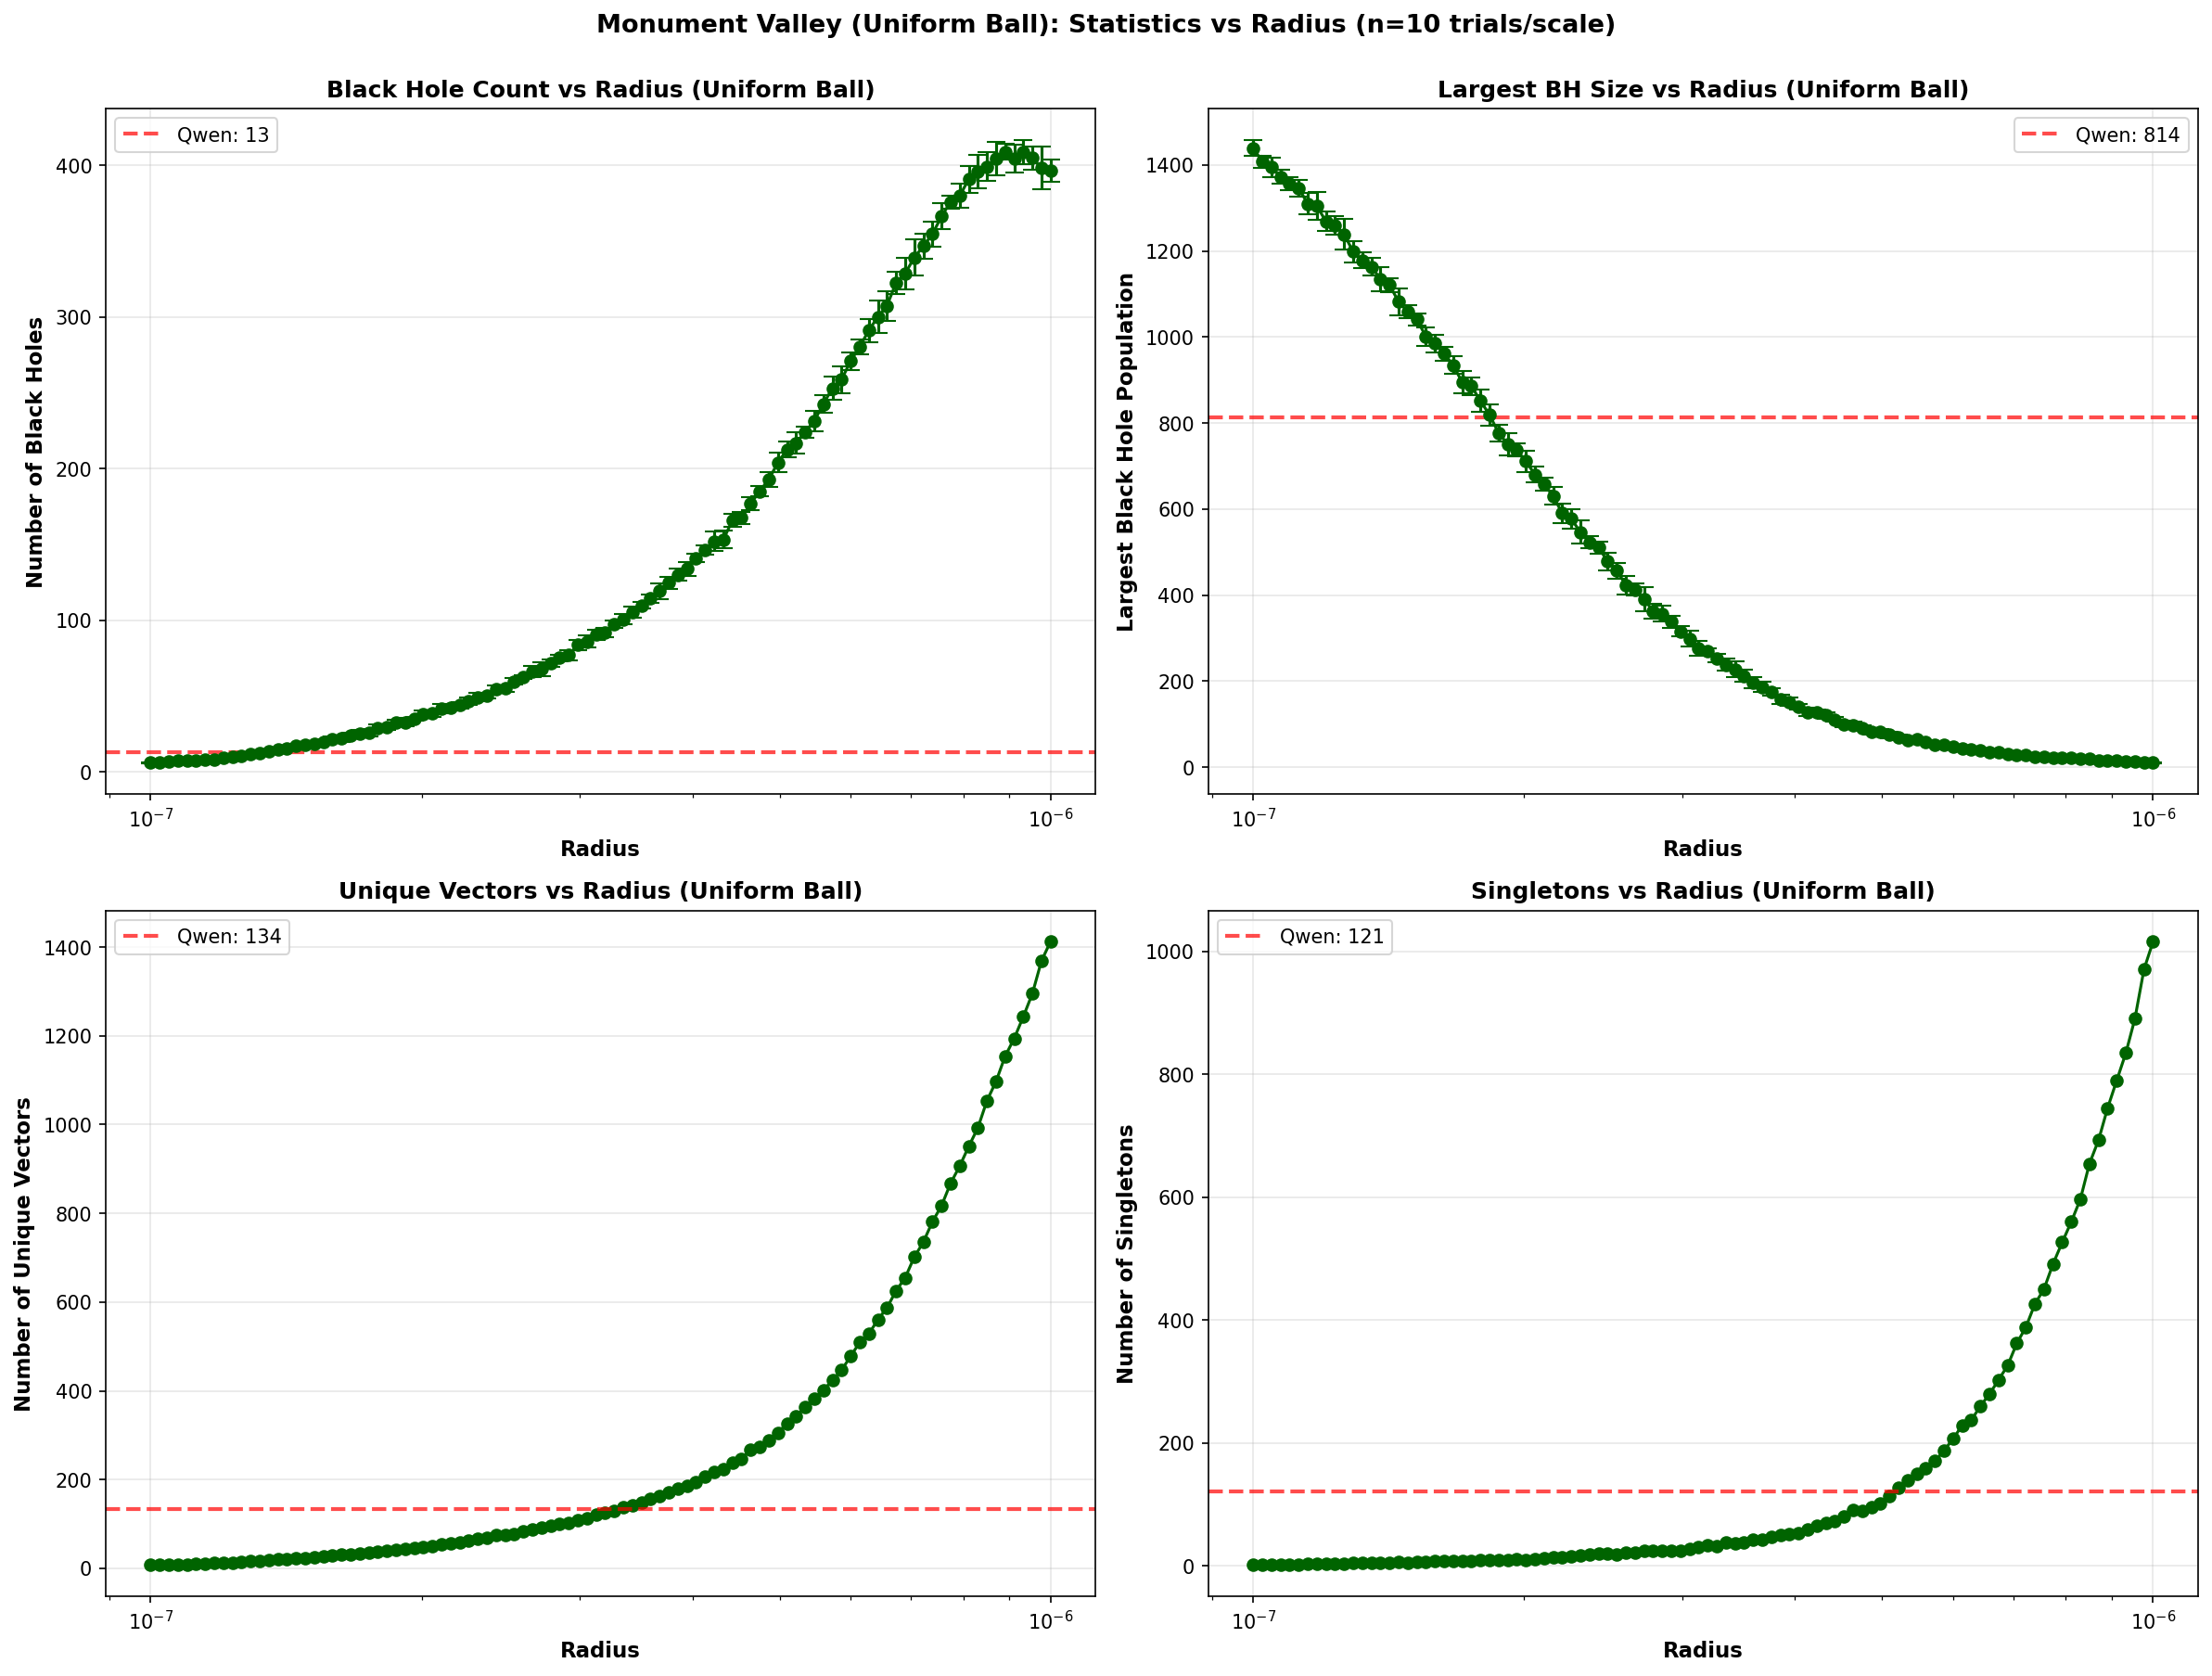

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12), dpi=DPI)

scales = [s['scale'] for s in summary_stats]

# Top-left: Number of black holes
ax = axes[0, 0]
n_bh_means = [s['n_black_holes_mean'] for s in summary_stats]
n_bh_stds = [s['n_black_holes_std'] for s in summary_stats]
ax.errorbar(scales, n_bh_means, yerr=n_bh_stds, marker='o', linestyle='-', capsize=5, color='darkgreen')
ax.axhline(len(qwen_demographics), color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Qwen: {len(qwen_demographics)}')
ax.set_xlabel('Radius', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Black Holes', fontsize=11, fontweight='bold')
ax.set_title('Black Hole Count vs Radius (Uniform Ball)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Top-right: Largest black hole size
ax = axes[0, 1]
largest_means = [s['largest_bh_mean'] for s in summary_stats]
largest_stds = [s['largest_bh_std'] for s in summary_stats]
ax.errorbar(scales, largest_means, yerr=largest_stds, marker='o', linestyle='-', capsize=5, color='darkgreen')
ax.axhline(qwen_demographics[0], color='red', linestyle='--', linewidth=2, alpha=0.7, label=f'Qwen: {qwen_demographics[0]}')
ax.set_xlabel('Radius', fontsize=11, fontweight='bold')
ax.set_ylabel('Largest Black Hole Population', fontsize=11, fontweight='bold')
ax.set_title('Largest BH Size vs Radius (Uniform Ball)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Bottom-left: Number of unique vectors
ax = axes[1, 0]
n_unique_means = [s['n_unique_mean'] for s in summary_stats]
ax.plot(scales, n_unique_means, marker='o', linestyle='-', color='darkgreen')
ax.axhline(134, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Qwen: 134')
ax.set_xlabel('Radius', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Unique Vectors', fontsize=11, fontweight='bold')
ax.set_title('Unique Vectors vs Radius (Uniform Ball)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Bottom-right: Number of singletons
ax = axes[1, 1]
n_single_means = [s['n_singletons_mean'] for s in summary_stats]
ax.plot(scales, n_single_means, marker='o', linestyle='-', color='darkgreen')
ax.axhline(121, color='red', linestyle='--', linewidth=2, alpha=0.7, label='Qwen: 121')
ax.set_xlabel('Radius', fontsize=11, fontweight='bold')
ax.set_ylabel('Number of Singletons', fontsize=11, fontweight='bold')
ax.set_title('Singletons vs Radius (Uniform Ball)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.suptitle(f'Monument Valley (Uniform Ball): Statistics vs Radius (n={N_TRIALS_PER_SCALE} trials/scale)',
             fontsize=13, fontweight='bold', y=1.00)

plt.tight_layout()
plt.show()

## Find Best Matching Scale

In [42]:
print("\nFinding best matching scale...\n")

# Score each scale by how close it is to Qwen's targets
# Use normalized distance in (n_black_holes, largest_bh) space

qwen_n_bh = len(qwen_demographics)
qwen_largest = qwen_demographics[0]

best_scale = None
best_distance = float('inf')

for stats in summary_stats:
    scale = stats['scale']
    n_bh = stats['n_black_holes_mean']
    largest = stats['largest_bh_mean']
    
    # Normalized distance (each component scaled by target value)
    dist_n_bh = abs(n_bh - qwen_n_bh) / qwen_n_bh
    dist_largest = abs(largest - qwen_largest) / qwen_largest
    
    total_dist = np.sqrt(dist_n_bh**2 + dist_largest**2)
    
    if total_dist < best_distance:
        best_distance = total_dist
        best_scale = scale
        best_stats = stats

print(f"Best matching radius: {best_scale:.6e}")
print(f"  n_black_holes: {best_stats['n_black_holes_mean']:.1f} ± {best_stats['n_black_holes_std']:.1f} (target: {qwen_n_bh})")
print(f"  largest_bh: {best_stats['largest_bh_mean']:.0f} ± {best_stats['largest_bh_std']:.0f} (target: {qwen_largest})")
print(f"  n_unique: {best_stats['n_unique_mean']:.1f} (target: 134)")
print(f"  n_singletons: {best_stats['n_singletons_mean']:.1f} (target: 121)")
print(f"\nNormalized distance from Qwen: {best_distance:.4f}")


Finding best matching scale...

Best matching radius: 1.417474e-07
  n_black_holes: 15.3 ± 1.4 (target: 13)
  largest_bh: 1121 ± 17 (target: 814)
  n_unique: 20.5 (target: 134)
  n_singletons: 5.2 (target: 121)

Normalized distance from Qwen: 0.4163


## Examine Demographics at Best Scale

In [43]:
print(f"\nExamining demographics at best scale ({best_scale:.6e})...\n")

best_results = all_results[best_scale]

# Collect all demographics lists
all_demographics = [r['demographics'] for r in best_results]

# Show a few examples
print("Example demographics from trials:\n")
for i in range(min(10, len(all_demographics))):
    demo = all_demographics[i]
    print(f"  Trial {i+1}: {demo[:10]}{'...' if len(demo) > 10 else ''}")

print(f"\nQwen (target): {qwen_demographics}")

# Find trial with demographics closest to Qwen
def compare_demographics(demo1, demo2):
    """Simple distance: sum of absolute differences in first N elements."""
    n = min(len(demo1), len(demo2))
    if n == 0:
        return float('inf')
    
    dist = sum(abs(demo1[i] - demo2[i]) for i in range(n))
    # Penalize length mismatch
    dist += abs(len(demo1) - len(demo2)) * 100
    return dist

closest_idx = None
closest_dist = float('inf')

for i, demo in enumerate(all_demographics):
    dist = compare_demographics(demo, qwen_demographics)
    if dist < closest_dist:
        closest_dist = dist
        closest_idx = i

print(f"\nClosest match to Qwen (trial {closest_idx+1}):")
print(f"  {all_demographics[closest_idx]}")
print(f"  Distance: {closest_dist:.0f}")


Examining demographics at best scale (1.417474e-07)...

Example demographics from trials:

  Trial 1: [1099, 660, 142, 117, 78, 71, 20, 6, 6, 5]...
  Trial 2: [1112, 686, 112, 109, 78, 66, 20, 8, 6, 5]...
  Trial 3: [1122, 621, 162, 100, 82, 80, 22, 7, 7, 5]...
  Trial 4: [1110, 657, 130, 122, 82, 65, 19, 8, 4, 4]...
  Trial 5: [1115, 666, 145, 105, 74, 57, 16, 9, 5, 4]...
  Trial 6: [1154, 643, 132, 103, 72, 59, 20, 9, 5, 5]...
  Trial 7: [1127, 648, 119, 115, 77, 74, 22, 7, 7, 5]...
  Trial 8: [1148, 622, 127, 117, 89, 57, 20, 9, 7, 4]...
  Trial 9: [1110, 655, 130, 122, 80, 64, 18, 10, 6, 5]...
  Trial 10: [1110, 658, 133, 116, 85, 67, 17, 9, 5, 4]...

Qwen (target): [814, 704, 306, 228, 11, 10, 6, 5, 4, 4, 3, 3, 2]

Closest match to Qwen (trial 1):
  [1099, 660, 142, 117, 78, 71, 20, 6, 6, 5, 4, 4, 2]
  Distance: 752


## Save Results

In [44]:
print("\nSaving results...\n")

# Prepare tensors for saving
save_dict = {
    'scale_min': torch.tensor(SCALE_MIN, dtype=torch.float32),
    'scale_max': torch.tensor(SCALE_MAX, dtype=torch.float32),
    'n_scale_samples': torch.tensor(N_SCALE_SAMPLES, dtype=torch.int64),
    'scale_values': torch.tensor(SCALE_VALUES, dtype=torch.float32),
    'n_trials_per_scale': torch.tensor(N_TRIALS_PER_SCALE, dtype=torch.int64),
    'n_black_holes_mean': torch.tensor([s['n_black_holes_mean'] for s in summary_stats], dtype=torch.float32),
    'n_black_holes_std': torch.tensor([s['n_black_holes_std'] for s in summary_stats], dtype=torch.float32),
    'largest_bh_mean': torch.tensor([s['largest_bh_mean'] for s in summary_stats], dtype=torch.float32),
    'largest_bh_std': torch.tensor([s['largest_bh_std'] for s in summary_stats], dtype=torch.float32),
    'n_unique_mean': torch.tensor([s['n_unique_mean'] for s in summary_stats], dtype=torch.float32),
    'n_singletons_mean': torch.tensor([s['n_singletons_mean'] for s in summary_stats], dtype=torch.float32),
    'best_scale': torch.tensor(best_scale, dtype=torch.float32),
}

save_file(save_dict, OUTPUT_PATH)

print(f"✓ Saved to {OUTPUT_PATH}")
print(f"\nSaved tensors:")
for key in save_dict.keys():
    tensor = save_dict[key]
    if tensor.ndim == 0:
        print(f"  {key}: scalar = {tensor.item()}")
    else:
        print(f"  {key}: shape={tensor.shape}, dtype={tensor.dtype}")


Saving results...

✓ Saved to ../data/tensors/13.3c_monument_valley_uniform_ball.safetensors

Saved tensors:
  scale_min: scalar = 1.0000000116860974e-07
  scale_max: scalar = 9.999999974752427e-07
  n_scale_samples: scalar = 100
  scale_values: shape=torch.Size([100]), dtype=torch.float32
  n_trials_per_scale: scalar = 10
  n_black_holes_mean: shape=torch.Size([100]), dtype=torch.float32
  n_black_holes_std: shape=torch.Size([100]), dtype=torch.float32
  largest_bh_mean: shape=torch.Size([100]), dtype=torch.float32
  largest_bh_std: shape=torch.Size([100]), dtype=torch.float32
  n_unique_mean: shape=torch.Size([100]), dtype=torch.float32
  n_singletons_mean: shape=torch.Size([100]), dtype=torch.float32
  best_scale: scalar = 1.4174742091199732e-07


## Summary

In [45]:
print(f"\n{'='*100}")
print(f"MONUMENT VALLEY SIMULATION COMPLETE (UNIFORM BALL)")
print(f"{'='*100}")
print(f"\nHypothesis tested:")
print(f"  Initialize {N_TOTAL_TOKENS:,} tokens uniformly in ball of radius R")
print(f"  Quantize to bfloat16")
print(f"  Uniformly delete {N_TOTAL_TOKENS - N_SURVIVORS:,} tokens (simulate random training)")
print(f"  Measure demographics of {N_SURVIVORS:,} survivors")
print(f"\nScale sweep:")
print(f"  Range: {SCALE_MIN:.2e} to {SCALE_MAX:.2e}")
print(f"  Samples: {N_SCALE_SAMPLES} (log-spaced)")
print(f"  {N_TRIALS_PER_SCALE} trials per scale")
print(f"  Total trials: {len(SCALE_VALUES) * N_TRIALS_PER_SCALE:,}")
print(f"\nBest match: R = {best_scale:.6e}")
print(f"  n_black_holes: {best_stats['n_black_holes_mean']:.1f} ± {best_stats['n_black_holes_std']:.1f} (Qwen: {qwen_n_bh})")
print(f"  largest_bh: {best_stats['largest_bh_mean']:.0f} ± {best_stats['largest_bh_std']:.0f} (Qwen: {qwen_largest})")
print(f"\nNext steps:")
print(f"  - If results look promising: narrow radius range for finer resolution")
print(f"  - Compare demographics distributions to Qwen")
print(f"  - Test if uniform ball reproduces spatial extent (L∞ distances)")
print(f"\n{'='*100}")


MONUMENT VALLEY SIMULATION COMPLETE (UNIFORM BALL)

Hypothesis tested:
  Initialize 151,936 tokens uniformly in ball of radius R
  Quantize to bfloat16
  Uniformly delete 149,715 tokens (simulate random training)
  Measure demographics of 2,221 survivors

Scale sweep:
  Range: 1.00e-07 to 1.00e-06
  Samples: 100 (log-spaced)
  10 trials per scale
  Total trials: 1,000

Best match: R = 1.417474e-07
  n_black_holes: 15.3 ± 1.4 (Qwen: 13)
  largest_bh: 1121 ± 17 (Qwen: 814)

Next steps:
  - If results look promising: narrow radius range for finer resolution
  - Compare demographics distributions to Qwen
  - Test if uniform ball reproduces spatial extent (L∞ distances)

